In [ ]:
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [180]:
import sys
custom_modules = [mod for mod in sys.modules if mod.startswith('utils.') or mod.startswith('neuronModels.')]
for module in custom_modules:
    del sys.modules[module]
from neuronModels.FitzhughNagumo_model import FitzhughNagumo_model
from neuronModels.GRUNetwork import GRUNetwork
from neuronModels.HybridModel import HybridModel
from neuronModels.IzhikevichModel import izhikevich_model
from neuronModels.LifModel import LifModel
from utils.DataHandler import DataHandler
from utils.Plotter import Plotter
from utils.Logger import Logger, LogLevel
from utils.Constants import Constants

logger = Logger()
logger.log("Librerie Buildate", LogLevel.INFO)

[2025-03-15 09:26:48] [INFO] Librerie Buildate


Dati di banchmark articolo [1]:


In [102]:

# Calculate adjacency matrix G using Kronecker product
G = DataHandler.generate_adjacency_matrix(Constants.A1, n=3)

In [103]:
# FitzHugh-Nagumo Model
hybrid_model = HybridModel()
fn_model = FitzhughNagumo_model(Constants.N, Constants.EPSILON, Constants.SIGMA, Constants.A, Constants.B, G)

t,sol = fn_model._generate_synthetic_data()
logger.log("LGenerated synthetic data for FitzHugh-Nagumo model")

[2025-03-14 23:47:16] [INFO] LGenerated synthetic data for FitzHugh-Nagumo model


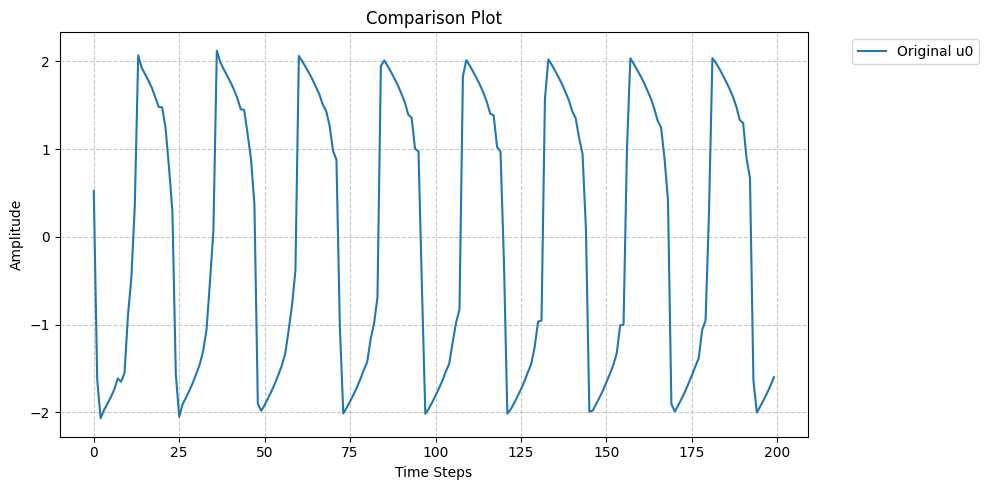

In [104]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(sol[:200,i], label=f'Original u{i}')
       
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(sol, num_series=1, time_steps=200, var_name='u')

In [106]:

x,y = hybrid_model._prepare_data(sol)
x_train, y_train, x_test, y_test = hybrid_model._split_train_test(x,y)

In [107]:

model = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 200 )
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)


Epoch [20/200], Train Loss: 0.0602 
Epoch [40/200], Train Loss: 0.0319 
Epoch [60/200], Train Loss: 0.0237 
Epoch [80/200], Train Loss: 0.0182 
Epoch [100/200], Train Loss: 0.0127 
Epoch [120/200], Train Loss: 0.0086 
Epoch [140/200], Train Loss: 0.0065 
Epoch [160/200], Train Loss: 0.0056 
Epoch [180/200], Train Loss: 0.0047 
Epoch [200/200], Train Loss: 0.0041 


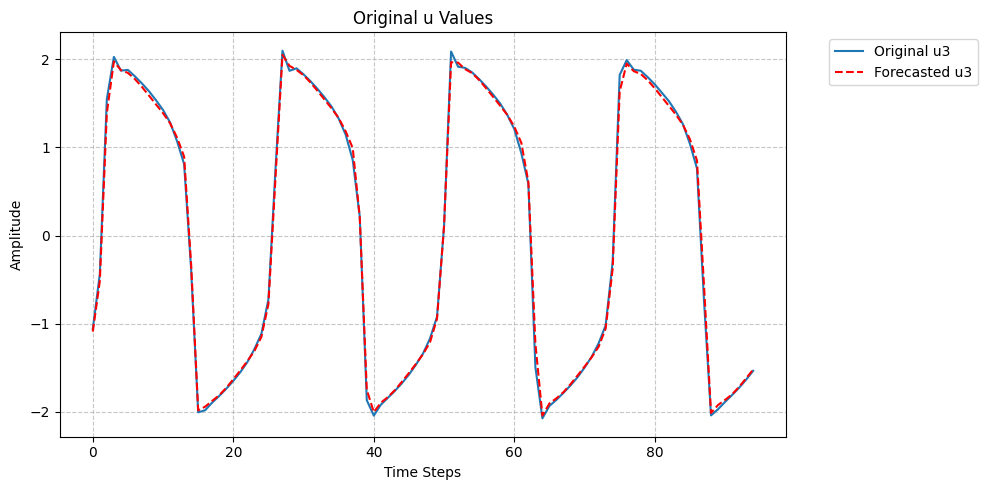

In [108]:
#sol = hybrid_model._standardize(sol)
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 3], label=f'Original u{i}')
        plt.plot(forecasted[:200,3], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=3,
    time_steps=200,
    var_name='u',
    title='Original u Values'
)


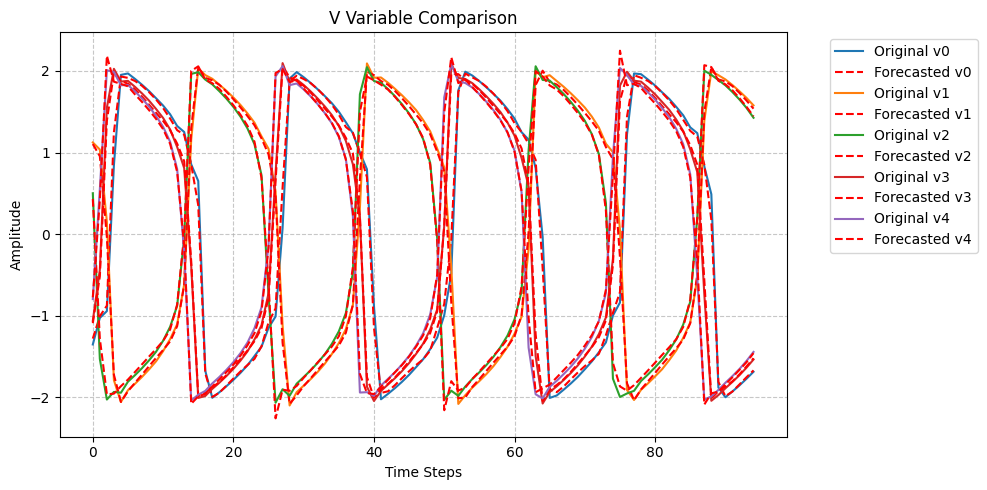

In [109]:
Plotter.plot_data(y_test, forecasted, index=39, var_name='v', 
                       time_steps=95, title='V Variable Comparison')


In [110]:
x_error, y_error = hybrid_model.create_error_sequences(model_data = sol , true_data = sol)
model_corrections = hybrid_model._create_gru(len(sol[1]),len(sol[1]), same_size = True)
optimizer = optim.Adam(model_corrections.parameters(), lr=0.001)
trained_model_corrections = hybrid_model._train(model_corrections,x_error,y_error,optimizer,epochs = 200 )
forecast = hybrid_model._forecast(trained_model_corrections, x_test, y_test, corrections=True)

Epoch [20/200], Train Loss: 0.0002 
Epoch [40/200], Train Loss: 0.0000 
Epoch [60/200], Train Loss: 0.0000 
Epoch [80/200], Train Loss: 0.0000 
Epoch [100/200], Train Loss: 0.0000 
Epoch [120/200], Train Loss: 0.0000 
Epoch [140/200], Train Loss: 0.0000 
Epoch [160/200], Train Loss: 0.0000 
Epoch [180/200], Train Loss: 0.0000 
Epoch [200/200], Train Loss: 0.0000 


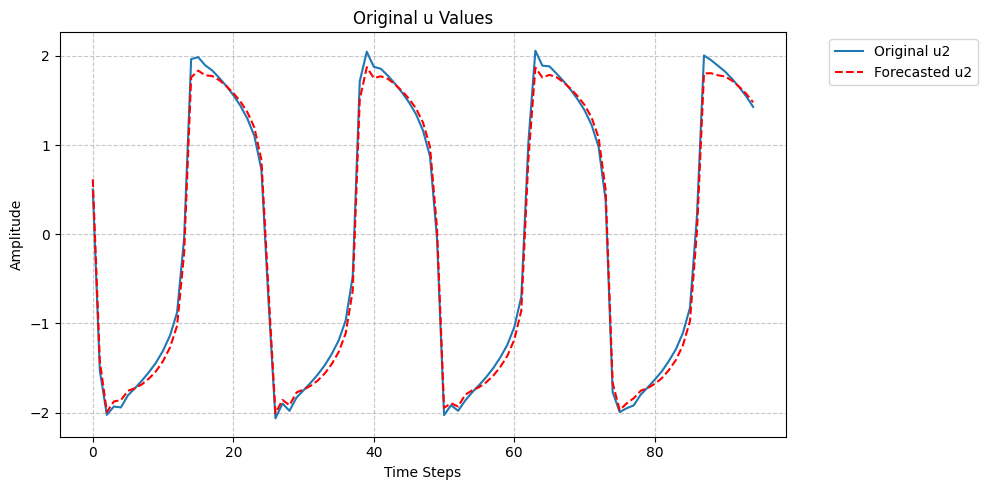

In [111]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 2], label=f'Original u{i}')
        plt.plot(forecast[:200,2], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecast,
    index=2,  # since you were using index 2 in the original code
    time_steps=200,
    var_name='u',
    title='Original u Values'
)

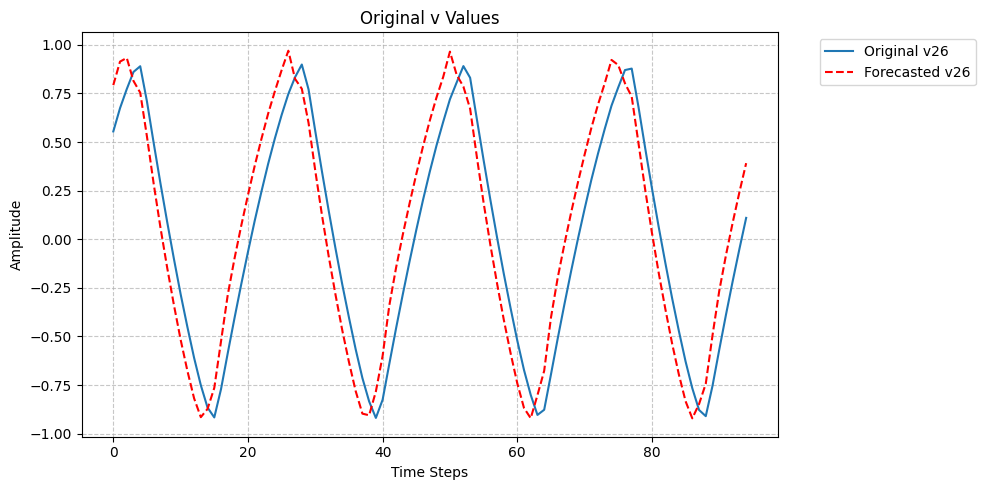

In [112]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:200, 26], label=f'Original v{i}')
        plt.plot(forecast[:200,26], label=f'Corrected v{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecast,
    index=26,
    time_steps=200,
    var_name='v',  # Note: changed to 'v' since this plots v variable
    title='Original v Values'  # Also updated title to reflect v variable
)

PEZZO DA CONTROLLARE + classe IZHIKEVIC

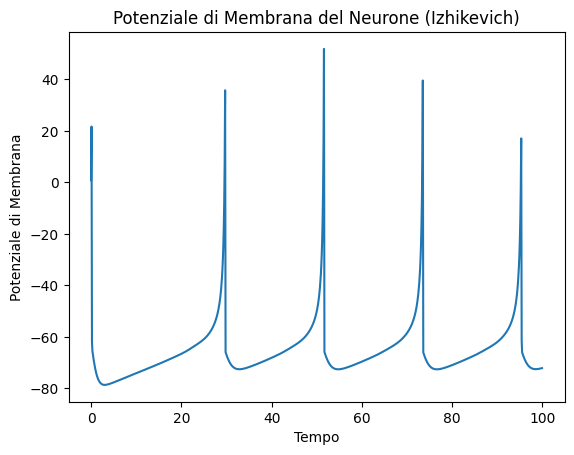

In [151]:


izh_model = izhikevich_model(N=20, a=0.05, b=0.2, c=-65, d=8, I=10)
t, data = izh_model._generate_synthetic_data(T=100, dt=0.1)
hybrid_model = HybridModel()

plt.plot(t, data[:, 1])  
plt.title("Potenziale di Membrana del Neurone (Izhikevich)")
plt.xlabel("Tempo")
plt.ylabel("Potenziale di Membrana")
plt.show()

In [152]:

x,y = hybrid_model._prepare_data(data)
x_train, y_train, x_test, y_test = hybrid_model._split_train_test(x,y)

In [154]:
model = hybrid_model._create_gru(len(data[1]),len(data[1]), same_size = True)
optimizer = optim.Adam(model.parameters(), lr=0.1)
trained_model = hybrid_model._train(model,x_train,y_train,optimizer,epochs = 200 )
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)

Epoch [20/200], Train Loss: 0.2651 
Epoch [40/200], Train Loss: 0.1120 
Epoch [60/200], Train Loss: 0.0782 
Epoch [80/200], Train Loss: 0.0646 
Epoch [100/200], Train Loss: 0.0570 
Epoch [120/200], Train Loss: 0.0508 
Epoch [140/200], Train Loss: 0.0471 
Epoch [160/200], Train Loss: 0.0438 
Epoch [180/200], Train Loss: 0.0390 
Epoch [200/200], Train Loss: 0.0362 


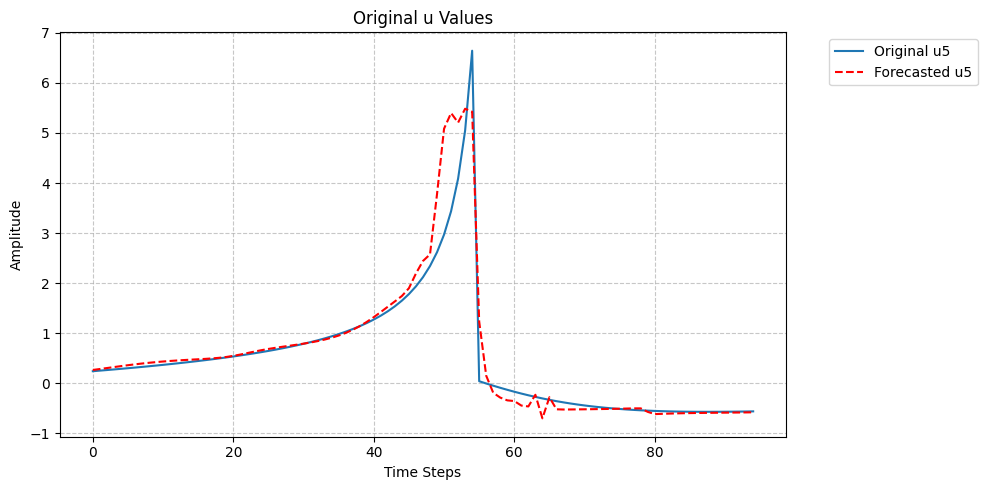

In [156]:
#sol = hybrid_model._standardize(sol)
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(y_test[:, 5], label=f'Original u{i}')
        plt.plot(forecasted[:,5], label=f'Corrected u{i}', color='red', linestyle='dashed')
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=5,
    time_steps=y_test.shape[0],  # Using full length since no slice was specified
    var_name='u',
    title='Original u Values'
)


Da capire se mettere tutte le variabili perchè è più bellino o creare l'oggetto con le variabili di default. 
Nota: le costanti specifiche dei modelli nella rispettiva classe, mentre quelle globali (numero di neuroni), nel file delle costanti.

In [181]:
# LIF Model
lif_model = LifModel(
    N=20,              # Number of neurons
    tau=10.0,          # Membrane time constant (ms) - reduced for faster response
    R=5.0,             # Membrane resistance (MΩ) - increased for stronger response
    I=10.0,            # Input current (pA) - reduced to avoid saturation
    V_rest=-65,        # Resting potential (mV)
    V_th=-55,          # Threshold potential (mV) - adjusted for more frequent spikes
    V_reset=-75        # Reset potential (mV)
)
#lif_model = LifModel()
t, V = lif_model.simulate(T=200, dt=0.1)
logger.log("Generated synthetic data for LIF model")

[2025-03-15 09:27:00] [INFO] Generated synthetic data for LIF model


In [182]:
lif_model = LifModel()
t, V = lif_model.simulate(T=200, dt=0.1)

Da Togliere?

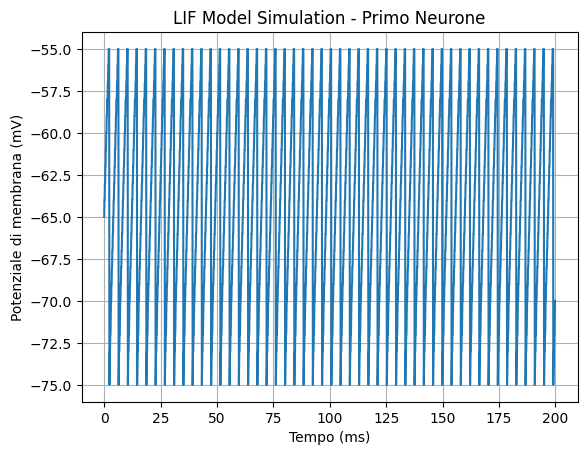

In [183]:
import matplotlib.pyplot as plt
plt.plot(t, V[:, 0])  # Visualizziamo il primo neurone
plt.title("LIF Model Simulation - Primo Neurone")
plt.xlabel("Tempo (ms)")
plt.ylabel("Potenziale di membrana (mV)")
plt.grid()
plt.show()

In [184]:
from sklearn.preprocessing import MinMaxScaler

# Normalize voltage data to [0,1] range
scaler = MinMaxScaler()
#V_normalized = scaler.fit_transform(V)
x, y = hybrid_model._prepare_data(V)
x_train, y_train, x_test, y_test = hybrid_model._split_train_test(x, y)

In [185]:
model = hybrid_model._create_gru(
    input_size=V.shape[1],  # number of neurons (20 in this case)
    output_size=V.shape[1], 
    same_size=True
)

# Setup optimizer and train
optimizer = optim.Adam(model.parameters(), lr=0.01)
trained_model = hybrid_model._train(model, x_train, y_train, optimizer, epochs=200)

# Generate forecasts
forecasted = hybrid_model._forecast(trained_model, x_test, y_test)

Epoch [20/200], Train Loss: 0.2416 
Epoch [40/200], Train Loss: 0.2186 
Epoch [60/200], Train Loss: 0.1706 
Epoch [80/200], Train Loss: 0.1562 
Epoch [100/200], Train Loss: 0.1022 
Epoch [120/200], Train Loss: 0.0305 
Epoch [140/200], Train Loss: 0.0958 
Epoch [160/200], Train Loss: 0.0168 
Epoch [180/200], Train Loss: 0.0039 
Epoch [200/200], Train Loss: 0.0027 


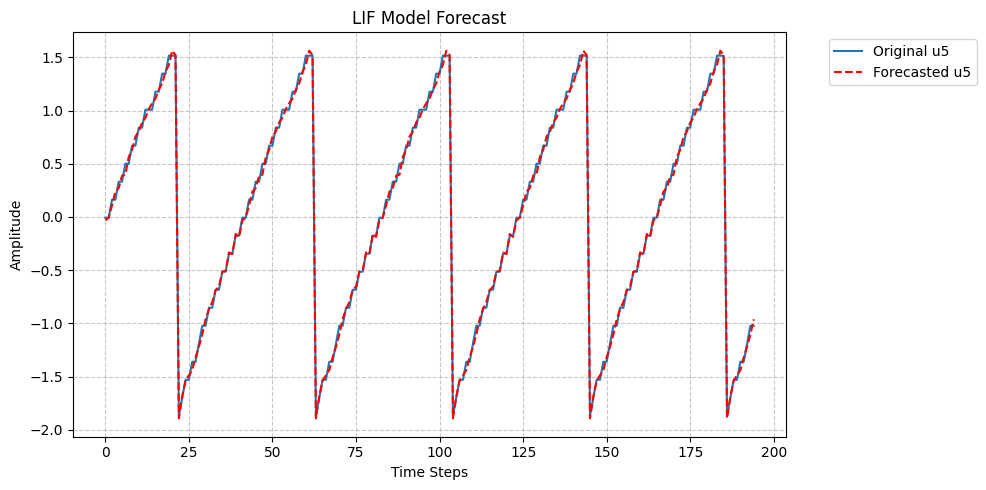

In [186]:
Plotter.plot_data(
    y_test=y_test,
    forecasted=forecasted,
    index=5,
    time_steps=y_test.shape[0],
    var_name='u',
    title='LIF Model Forecast'
)

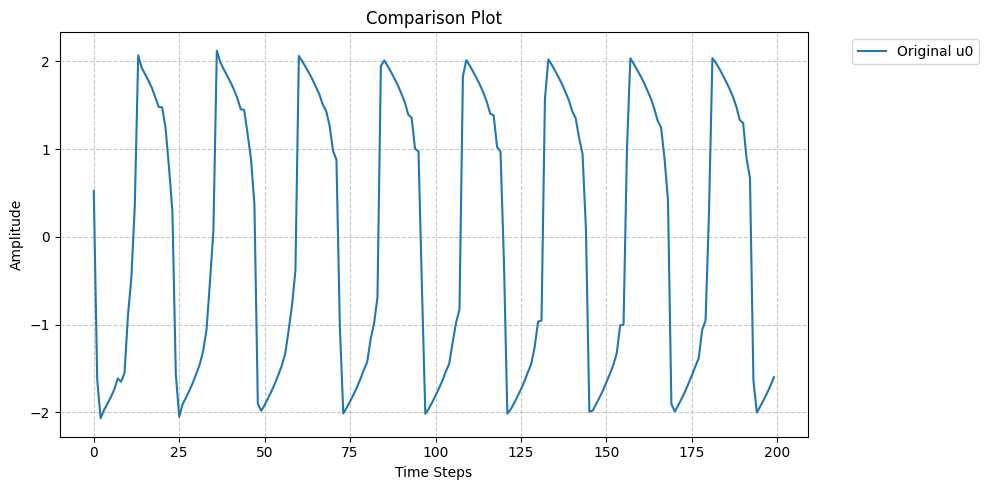

In [122]:
'''for i in range(1):  # Limit to 5 neurons for readability
        plt.plot(sol[:200,i], label=f'Original u{i}')
       
plt.title('Original u Values')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)'''
Plotter.plot_data(sol, num_series = 1)